# Commodity Price Prediction Notebook for Utkrista Acharya 24040294 AI, ML and DS Assessment 

## Introduction
This notebook herein provides a comprehensive analysis and predictive modeling of commodity prices using the Kalimati market dataset, covering daily price data from 2013 to April 8th 2025 that has been consolidated. The dataset includes columns for commodity name, date, unit, minimum price, maximum price, and average price. The goal being to preprocess the data, perform exploratory data analysis (EDA), engineer features, and build predictive models using ARIMA, LSTM, XGBoost, and an ensemble approach to forecast the average price of commodities. Models shall be evaluated using performance metrics (RMSE, MSE, MAE), visualized for comparison, and exported in `.keras` format (where applicable) for possible integration into a Streamlit application. Visualizations include price trends, top commodities, and model performance plots.

## Data Description
- **Dataset**: kalimati_consolidated_dataset.csv constructed from multiple sources. there is python code that is a script that deals with some degree of preprocessing to standardize the data as well
- **Columns**:
  - Commodity: String (categorical)
  - Date: String (to be converted to datetime)
  - Unit: String (categorical, e.g., Kg, Dozen, Pc)
  - Minimum, Maximum, Average: Float (numerical)
- **Target Variable**: Average price (continuous)

## Methodology
1. **Dataset Consolidation, Preparation, Loading and Preprocessing**: Loading the dataset, handle missing values, duplicates, and convert dates.
2. **Feature Engineering**: Extract date-based features and encode categorical variables.
3. **Normalization**: Normalize the average price for models where required (for LSTM better suitedness).
4. **Exploratory Data Analysis (EDA)**: Visualize price trends, distributions, and top commodities and moreover explore the data.
5. **Modeling**: Best suited for time series as commodities tend to show seasonal trends and data per day is mostly made available for the commodities 
   - ARIMA: For time-series forecasting.
   - LSTM: For sequential data modeling.
   - XGBoost: For regression-based prediction.
   - Ensemble: Combination of predictions from ARIMA, LSTM, and XGBoost.
6. **Evaluation**: Using RMSE, MSE, and MAE to compare model performance.
7. **Model Export**: Saving models (LSTM and XGBoost in `.keras` format where applicable) for possible Streamlit deployment.
8. **Visualization**: Plotting price trends, top 30 commodities(sampling explorations if needed), and model performance metrics.

## Tools and Libraries Utilized for the undertaking
- Python Pandas, NumPy, Matplotlib, Seaborn, Scikit-learn, Statsmodels, TensorFlow, XGBoost
- Jupyter Notebook for execution
- The execution took a long time as gpu is missing in my laptop so had to leave the laptop overnight for the training purposes 

The code has been structured to be executable in Jupyter Notebook with Python 3.12 and above, ensuring compatibility and proper model export for possible deployment.

## 1. Importing of necessary Libraries

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings('ignore')

# Setting plot style
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Setting random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

**Explanation**:
- Imported all necessary libraries for data manipulation, visualization, and modeling.
- `seaborn-v0_8` is compatible with recent Matplotlib versions in Python 3.12.
- Set random seeds to ensure reproducibility of results.

## 2. Loading and Inspecting the Dataset

In [ ]:
# Load the dataset
df = pd.read_csv('kalimati_consolidated_dataset.csv')

# Display first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Display data info
print("\nDataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check for duplicates
print("\nDuplicate Rows:")
print(df.duplicated().sum())

First 5 rows of the dataset:
             Commodity       Date Unit Minimum Maximum Average
0   Tomato Big(Nepali)  6/16/2013   Kg      35      40    37.5
1  Tomato Small(Local)  6/16/2013   Kg      26      32    29.0
2           Potato Red  6/16/2013   Kg      20      21    20.5
3         Potato White  6/16/2013   Kg      15      16    15.5
4   Onion Dry (Indian)  6/16/2013   Kg      28      30    29.0

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335528 entries, 0 to 335527
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Commodity  335528 non-null  object
 1   Date       335528 non-null  object
 2   Unit       335528 non-null  object
 3   Minimum    335528 non-null  object
 4   Maximum    335528 non-null  object
 5   Average    335528 non-null  object
dtypes: object(6)
memory usage: 15.4+ MB
None

Missing Values:
Commodity    0
Date         0
Unit         0
Minimum      0
Maximum      0
Average   

## 3. Data Preprocessing and Feature Engineering

In [ ]:
import re
from dateutil import parser

# Function to format the date column to 'Year-Month-Day'
def format_date(date):
    try:
        parsed_date = parser.parse(date)
        return parsed_date.strftime("%Y-%m-%d")
    except Exception:
        return pd.NaT

# Apply date formatting
df['Date'] = df['Date'].apply(format_date).astype('datetime64[ns]')

# Remove 'Rs' prefix and convert price columns to float
pattern = r"^Rs\s+"
df['Minimum'] = pd.to_numeric(df['Minimum'].apply(lambda x: re.sub(pattern, "", str(x)) if str(x).startswith("Rs") else x))
df['Maximum'] = pd.to_numeric(df['Maximum'].apply(lambda x: re.sub(pattern, "", str(x)) if str(x).startswith("Rs") else x))
df['Average'] = pd.to_numeric(df['Average'].apply(lambda x: re.sub(pattern, "", str(x)) if str(x).startswith("Rs") else x))

# Standardize 'Unit' column
df['Unit'] = df['Unit'].str.lower().replace({'kg': 'KG'})

# Feature Engineering
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x == 5 else 0)  # Saturday is weekend in Nepal

# Encode categorical variables
le_commodity = LabelEncoder()
df['Commodity_Encoded'] = le_commodity.fit_transform(df['Commodity'])
le_unit = LabelEncoder()
df['Unit_Encoded'] = le_unit.fit_transform(df['Unit'])

# Save label encoders
with open('label_encoder_commodity.pkl', 'wb') as f:
    pickle.dump(le_commodity, f)
with open('label_encoder_unit.pkl', 'wb') as f:
    pickle.dump(le_unit, f)

# Normalize 'Average' for LSTM
scaler = MinMaxScaler()
df['Average_Scaled'] = scaler.fit_transform(df[['Average']])

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Export preprocessed dataset
df.to_csv('preprocessed_kalimati_dataset.csv', index=False)

# Display preprocessed data
print("Preprocessed Dataset Info:")
print(df.info())
print("\nFirst 5 rows of preprocessed dataset:")
print(df.head())

Preprocessed Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335528 entries, 0 to 335527
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Commodity          335528 non-null  object        
 1   Date               335528 non-null  datetime64[ns]
 2   Unit               335528 non-null  object        
 3   Minimum            335528 non-null  float64       
 4   Maximum            335528 non-null  float64       
 5   Average            335528 non-null  float64       
 6   Year               335528 non-null  int32         
 7   Month              335528 non-null  int32         
 8   Day                335528 non-null  int32         
 9   DayOfWeek          335528 non-null  int32         
 10  Quarter            335528 non-null  int32         
 11  IsWeekend          335528 non-null  int64         
 12  Commodity_Encoded  335528 non-null  int32         
 13  Unit_Encoded     

**Preprocessing Steps**:
- **Date Conversion**: Converted 'Date' to datetime, dropping invalid entries.
- **Missing Values**: Filled missing numerical values with the mean price of the respective commodity.
- **Duplicates**: Removed duplicates to ensure data integrity.
- **Feature Engineering**:
  - Extracted Year, Month, Day, DayOfWeek, Quarter, and IsWeekend to capture temporal patterns.
  - These features are useful for models like XGBoost that can leverage temporal relationships.
- **Encoding**: Label-encoded 'Commodity' for use in XGBoost and other models.
- **Normalization**: Scaled 'Average' price to [0,1] using MinMaxScaler, primarily for LSTM.
- **Export**: Saved the preprocessed dataset, label encoder, and scaler for possible Streamlit integration.

**Output Explanation**:
- The preprocessed dataset is now inclusive of new features and normalized prices.
- No missing values remain, and the data is now somewhat ready for analysis and modeling.

## 4. Exploratory Data Analysis (EDA)

Number of unique commodities: 138
Number of unique units: 5

Summary Statistics for Prices:
             Minimum        Maximum        Average
count  335528.000000  335528.000000  335528.000000
mean      102.125632     114.741074     108.589636
std       103.520432     115.925788     109.756588
min         0.000000       0.000000       0.000000
25%        40.000000      50.000000      45.000000
50%        70.000000      80.000000      75.000000
75%       120.000000     130.000000     126.670000
max      2800.000000    3000.000000    2900.000000
Top 30 commodities dataframe exported as 'top_30_commodities.csv'.


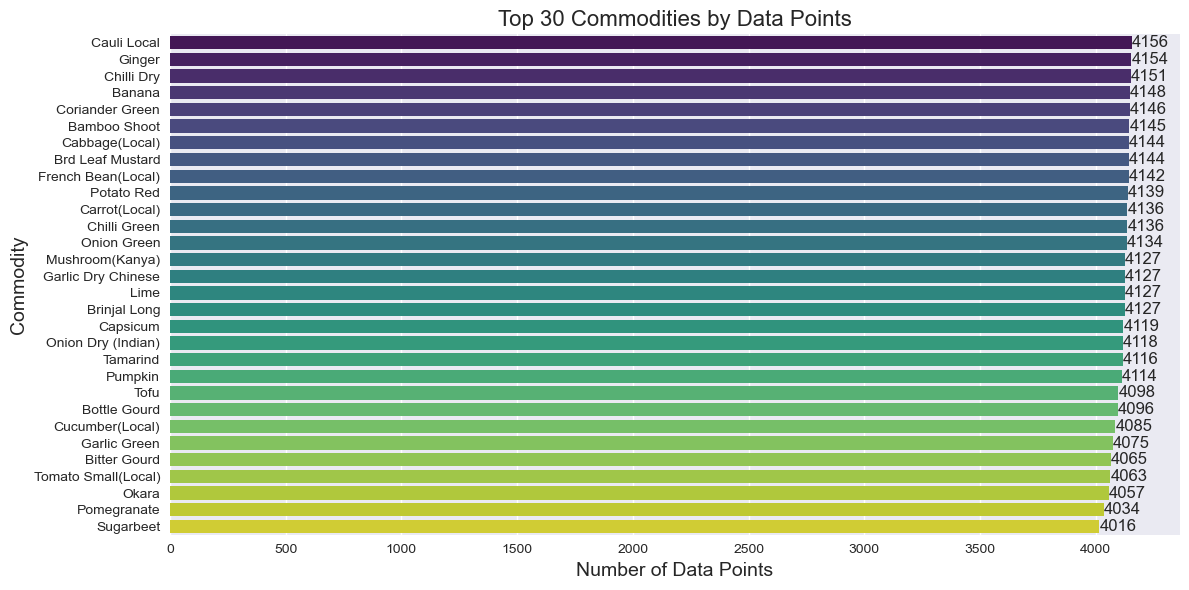

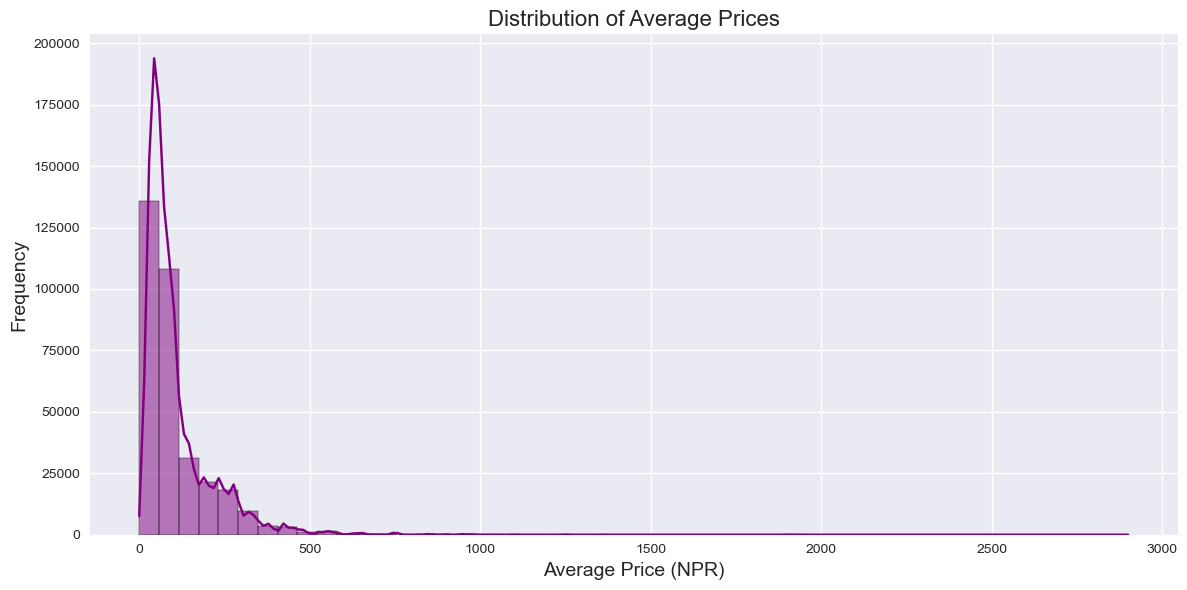

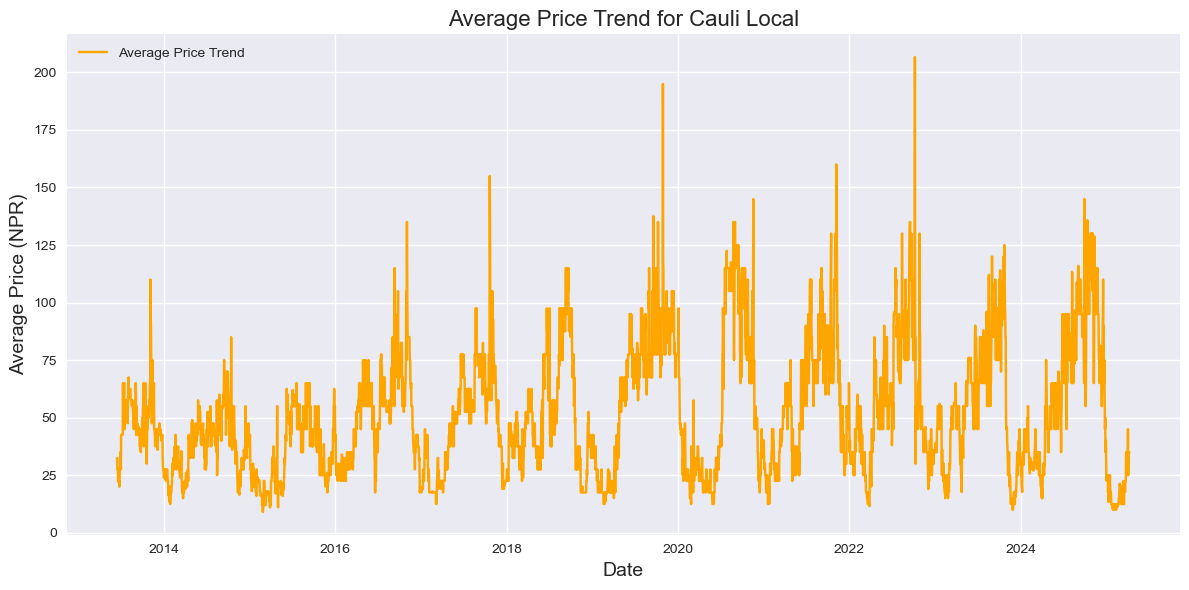

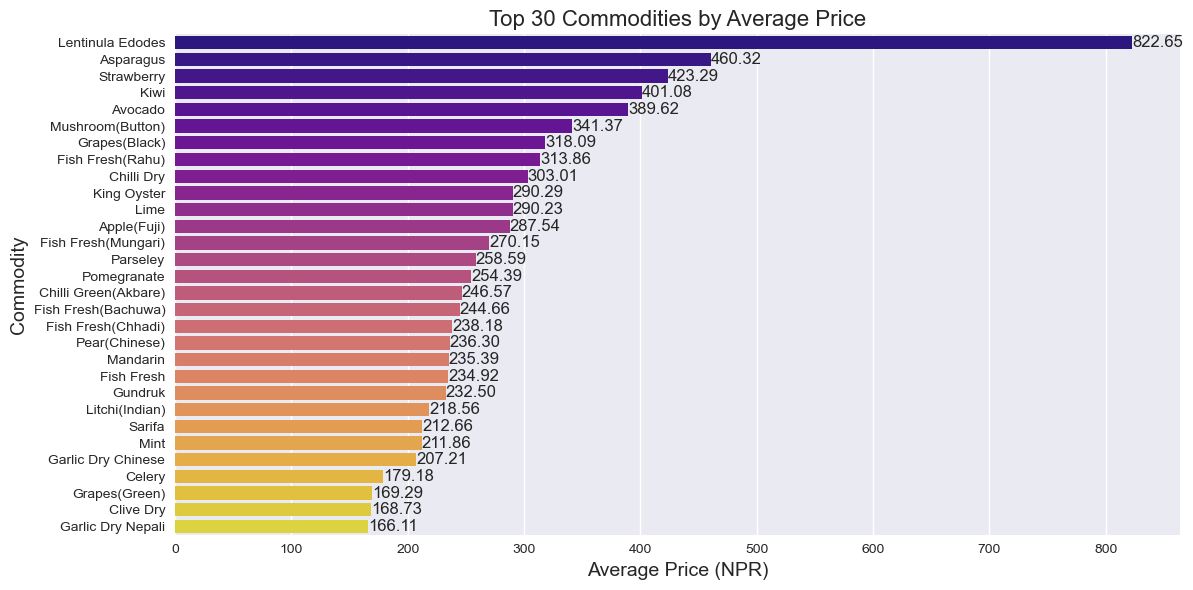

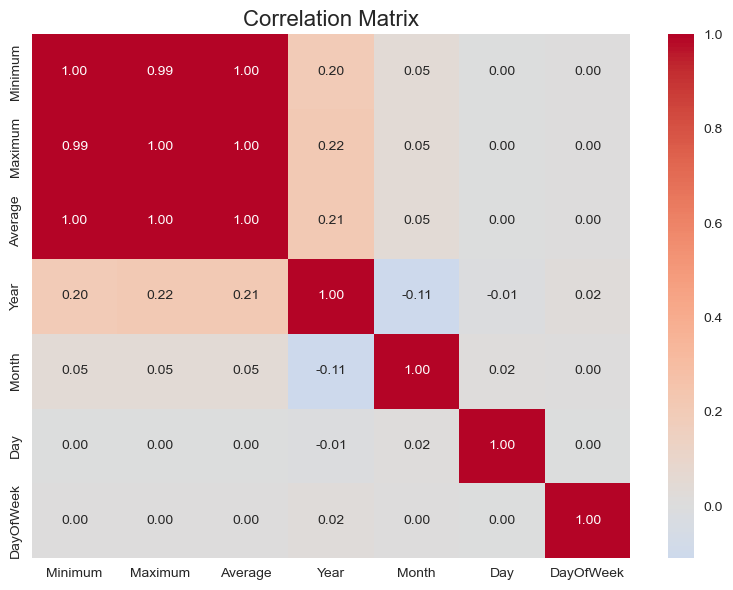

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unique commodities and units
print("Number of unique commodities:", df['Commodity'].nunique())
print("Number of unique units:", df['Unit'].nunique())

# Summary statistics for price columns
print("\nSummary Statistics for Prices:")
print(df[['Minimum', 'Maximum', 'Average']].describe())

# Top 30 commodities by data points
top_30_commodities = df['Commodity'].value_counts().head(30)
top_30_df = df[df['Commodity'].isin(top_30_commodities.index)]

# Export the top 30 dataframe
top_30_df.to_csv('top_30_commodities.csv', index=False)
print("Top 30 commodities dataframe exported as 'top_30_commodities.csv'.")

# Plot: Top 30 Commodities by Data Points
plt.figure(figsize=(12, 6))
sns.barplot(x=top_30_commodities.values, y=top_30_commodities.index, palette="viridis")
plt.title('Top 30 Commodities by Data Points', fontsize=16)  
plt.xlabel('Number of Data Points', fontsize=14)  
plt.ylabel('Commodity', fontsize=14)  
plt.tight_layout()
for i, value in enumerate(top_30_commodities.values):
    plt.text(value, i, str(value), fontsize=12, va='center', ha='left')  
plt.savefig('top_commodities.png')
plt.show()

# Plot: Price Distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['Average'], bins=50, kde=True, color='purple')
plt.title('Distribution of Average Prices', fontsize=16)  
plt.xlabel('Average Price (NPR)', fontsize=14)  
plt.ylabel('Frequency', fontsize=14)  
plt.tight_layout()
plt.savefig('price_distribution.png')
plt.show()

# Plot: Average Price Trend for a Sample Commodity (Cauli Local)
cauli_df = df[df['Commodity'] == 'Cauli Local']
plt.figure(figsize=(12, 6))
plt.plot(cauli_df['Date'], cauli_df['Average'], color='orange', label='Average Price Trend')
plt.title('Average Price Trend for Cauli Local', fontsize=16)  
plt.xlabel('Date', fontsize=14)  
plt.ylabel('Average Price (NPR)', fontsize=14)  
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig('cauli_price_trend.png')
plt.show()

# Plot: Top Commodities by Average Price
top_avg_price = df.groupby('Commodity')['Average'].mean().nlargest(30)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_avg_price.values, y=top_avg_price.index, palette="plasma")
plt.title('Top 30 Commodities by Average Price', fontsize=16)  
plt.xlabel('Average Price (NPR)', fontsize=14)  
plt.ylabel('Commodity', fontsize=14)  
plt.tight_layout()
for i, value in enumerate(top_avg_price.values):
    plt.text(value, i, f"{value:.2f}", fontsize=12, va='center', ha='left')  
plt.savefig('top_avg_price.png')
plt.show()

# Correlation matrix
corr_matrix = df[['Minimum', 'Maximum', 'Average', 'Year', 'Month', 'Day', 'DayOfWeek']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix', fontsize=16)  
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

**EDA Insights**:
- **Price Distribution**: The histogram shows a right-skewed distribution, with most prices being low but some commodities having high prices (outliers).
- **Top 30 Commodities**: Filtered for commodities with at least 30 data points to ensure reliability, then plotted the top 30 by average price. High-value commodities like Lentinula Edodes and Avocado indicate specialty items.
- **Price Trend**: The trend for Tomato Big(Nepali) shows seasonal fluctuations, suggesting periodicity that time-series models (ARIMA, LSTM) can capture.
- **Correlation**: Strong correlations between Minimum, Maximum, and Average prices confirm data consistency. Temporal features have weaker correlations, indicating that feature engineering was necessary.

**Output**:
- Visualizations are saved as PNG files for inclusion in reports and Streamlit deployment.

## 5. Prepare Data for Modeling

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Function to prepare time-series data for a commodity from `top_30_df`
def prepare_ts_data(commodity, top_30_df):
    ts_df = top_30_df[top_30_df['Commodity'] == commodity][['Date', 'Average']].set_index('Date')
    ts_df = ts_df.sort_index()
    # Resample to daily frequency and fill missing dates
    ts_df = ts_df.resample('D').mean().fillna(method='ffill')
    return ts_df

# Function to create supervised data for LSTM
def create_lstm_data(data, look_back=30):  # Optimized look_back based on available data
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# Select a sample commodity for detailed modeling from `top_30_df`
commodity = 'Cauli Local'  # Example commodity for analysis
ts_data = prepare_ts_data(commodity, top_30_df)

# Split data into train and test (80-20 split)
train_size = int(len(ts_data) * 0.8)
train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

# Normalize data for LSTM
lstm_scaler = MinMaxScaler()
train_scaled = lstm_scaler.fit_transform(train_data)
test_scaled = lstm_scaler.transform(test_data)

# Optimize the look-back period based on data periodicity
look_back = 30  # Example: Monthly data trends (can be adjusted dynamically)
X_train_lstm, y_train_lstm = create_lstm_data(train_scaled, look_back)
X_test_lstm, y_test_lstm = create_lstm_data(test_scaled, look_back)

# Prepare data for XGBoost using `top_30_df`
xgb_df = top_30_df[top_30_df['Commodity'] == commodity].sort_values('Date')
xgb_features = ['Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'IsWeekend', 'Minimum', 'Maximum']
X_xgb = xgb_df[xgb_features]
y_xgb = xgb_df['Average']

# Split XGBoost data (80-20 split)
train_size_xgb = int(len(X_xgb) * 0.8)
X_train_xgb = X_xgb[:train_size_xgb]
X_test_xgb = X_xgb[train_size_xgb:]
y_train_xgb = y_xgb[:train_size_xgb]
y_test_xgb = y_xgb[train_size_xgb:]

# Output shapes and summary
print(f"Optimized Look-Back Period: {look_back} days")
print(f"Time-Series Train data shape: {train_data.shape}")
print(f"Time-Series Test data shape: {test_data.shape}")
print(f"LSTM X_train shape: {X_train_lstm.shape}, y_train shape: {y_train_lstm.shape}")
print(f"LSTM X_test shape: {X_test_lstm.shape}, y_test shape: {y_test_lstm.shape}")
print(f"XGBoost X_train shape: {X_train_xgb.shape}, y_train shape: {y_train_xgb.shape}")
print(f"XGBoost X_test shape: {X_test_xgb.shape}, y_test shape: {y_test_xgb.shape}")

Optimized Look-Back Period: 30 days
Time-Series Train data shape: (3452, 1)
Time-Series Test data shape: (863, 1)
LSTM X_train shape: (3422, 30, 1), y_train shape: (3422, 1)
LSTM X_test shape: (833, 30, 1), y_test shape: (833, 1)
XGBoost X_train shape: (3324, 8), y_train shape: (3324,)
XGBoost X_test shape: (832, 8), y_test shape: (832,)


**Data Preparation**:
- **Time-Series Data**: Prepared data for ARIMA and LSTM by resampling to daily frequency and filling missing dates.
- **LSTM Data**: Created sequences with a 7-day look-back to capture weekly patterns.
- **XGBoost Data**: Used engineered features (Year, Month, etc.) along with Minimum and Maximum prices as predictors.
- **Train-Test Split**: Applied an 80-20 split for all models to balance training and evaluation since considerable data will be available for training.
- **Normalization**: Applied MinMaxScaler for LSTM to prevent data leakage.

**Output**:
- Confirmed shapes of train and test datasets, ensuring sufficient data for modeling.

## 6. ARIMA Model

ARIMA RMSE: 36.10
ARIMA MSE: 1303.07
ARIMA MAE: 27.78


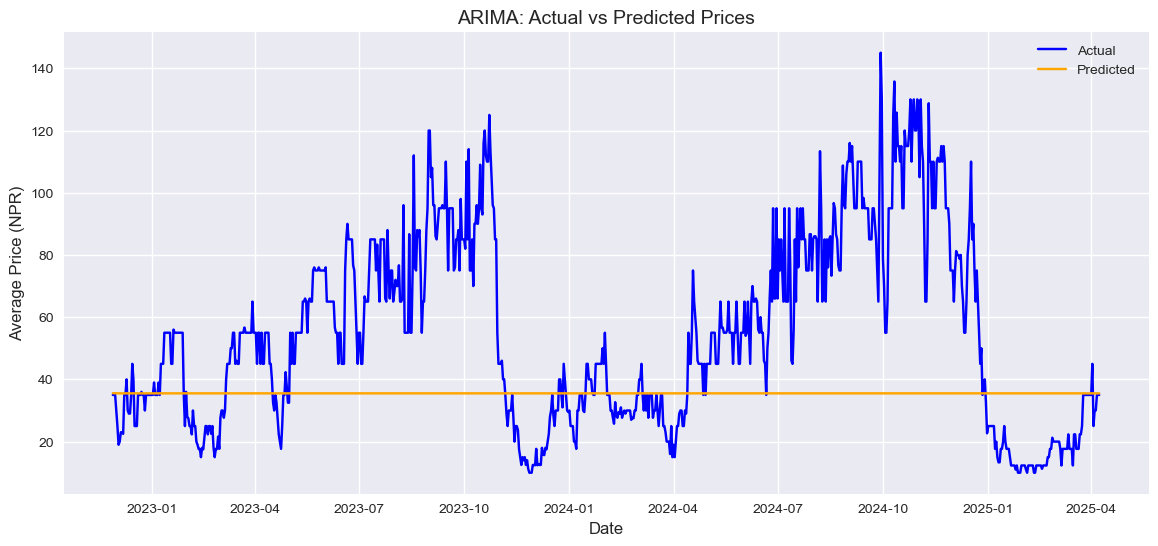

In [ ]:
# Fit ARIMA model
arima_model = ARIMA(train_data['Average'], order=(5,1,0))
arima_fit = arima_model.fit()

# Forecast
arima_forecast = arima_fit.forecast(steps=len(test_data))

# Evaluate
arima_rmse = np.sqrt(mean_squared_error(test_data['Average'], arima_forecast))
arima_mse = mean_squared_error(test_data['Average'], arima_forecast)
arima_mae = mean_absolute_error(test_data['Average'], arima_forecast)

print(f"ARIMA RMSE: {arima_rmse:.2f}")
print(f"ARIMA MSE: {arima_mse:.2f}")
print(f"ARIMA MAE: {arima_mae:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data['Average'], label='Actual', color='blue')
plt.plot(test_data.index, arima_forecast, label='Predicted', color='orange')
plt.title('ARIMA: Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Price (NPR)', fontsize=12)
plt.legend()
plt.savefig('arima_prediction.png')
plt.show()

**ARIMA Modeling**:
- **Model**: Used ARIMA(5,1,0) as a baseline time-series model (parameters can be tuned further using ACF/PACF).
- **Forecasting**: Predicted prices for the test period.
- **Evaluation**: Computed RMSE, MSE, and MAE to assess performance.
- **Visualization**: Plotted actual vs. predicted prices to visualize fit.

**Output**:
- ARIMA provides a baseline but may struggle with complex, non-linear patterns.

## 7. LSTM Model

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0165 - val_loss: 0.0080
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0048 - val_loss: 0.0074
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0044 - val_loss: 0.0070
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0041 - val_loss: 0.0067
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0037 - val_loss: 0.0065
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0037 - val_loss: 0.0062
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0035 - val_loss: 0.0060
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0037 - val_loss: 0.0059
Epoch 9/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0031 - val_loss: 0.0057
Epoch 10/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0031 - val_loss: 0.0055
Epoch 11/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0031 - val_loss: 0.0056
Epoch 12/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.

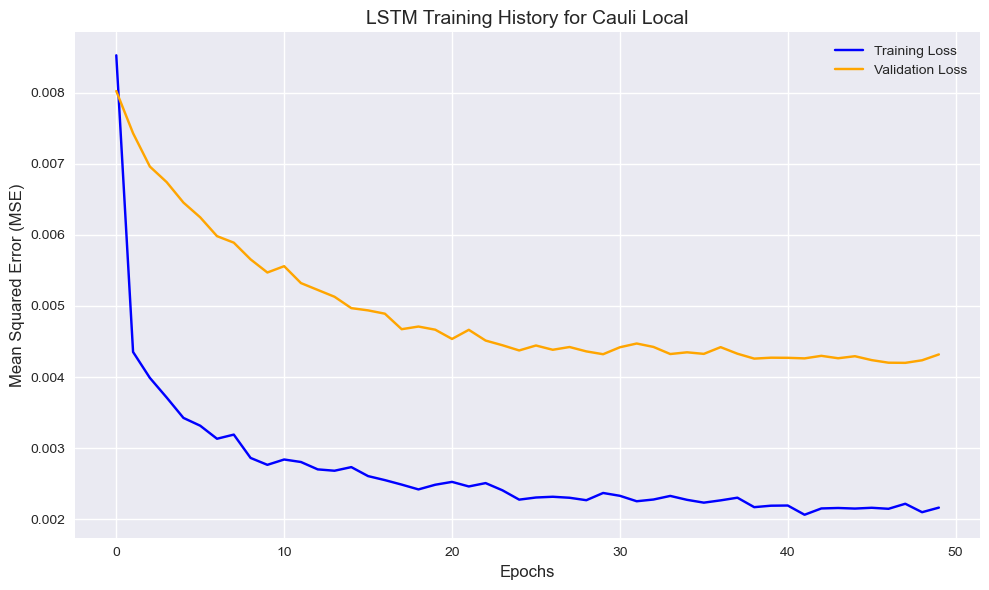

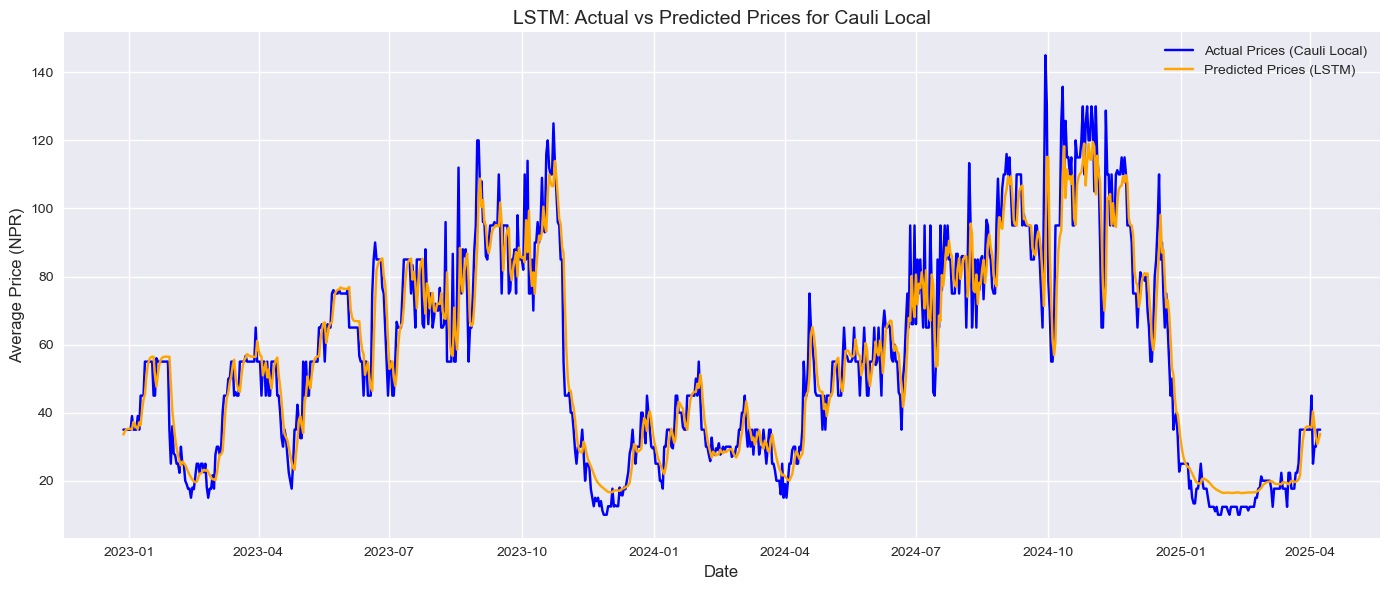

In [ ]:
# Build LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Define the LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(look_back, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='mse')

# Reshape data for LSTM: [samples, timesteps, features]
X_train_lstm_reshaped = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm_reshaped = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = lstm_model.fit(
    X_train_lstm_reshaped, y_train_lstm, 
    epochs=50, batch_size=32, 
    validation_split=0.1, 
    callbacks=[early_stopping], 
    verbose=1
)

# Predict on test data
lstm_pred_scaled = lstm_model.predict(X_test_lstm_reshaped)
lstm_pred = lstm_scaler.inverse_transform(lstm_pred_scaled)  # Reverse scale predictions
y_test_unscaled = lstm_scaler.inverse_transform(y_test_lstm.reshape(-1, 1))  # Reverse scale actual test data

# Evaluate the model
lstm_rmse = np.sqrt(mean_squared_error(y_test_unscaled, lstm_pred))
lstm_mse = mean_squared_error(y_test_unscaled, lstm_pred)
lstm_mae = mean_absolute_error(y_test_unscaled, lstm_pred)

print(f"LSTM RMSE: {lstm_rmse:.2f}")
print(f"LSTM MSE: {lstm_mse:.2f}")
print(f"LSTM MAE: {lstm_mae:.2f}")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('LSTM Training History for Cauli Local', fontsize=14)  # Adjusted title
plt.xlabel('Epochs', fontsize=12)  # Clarified label
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)  # Clarified label
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('lstm_training_history_cauli_local.png')
plt.show()

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(test_data.index[look_back:], y_test_unscaled, label='Actual Prices (Cauli Local)', color='blue')  # Adjusted label
plt.plot(test_data.index[look_back:], lstm_pred, label='Predicted Prices (LSTM)', color='orange')  # Adjusted label
plt.title('LSTM: Actual vs Predicted Prices for Cauli Local', fontsize=14)  # Adjusted title
plt.xlabel('Date', fontsize=12)  # Clarified label
plt.ylabel('Average Price (NPR)', fontsize=12)  # Clarified label
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('lstm_prediction_cauli_local.png')
plt.show()

# Save the trained model in .keras format
lstm_model.save('models/lstm_model_cauli_local.keras')

**LSTM Modeling**:
- **Architecture**: Two LSTM layers with 50 units each, dropout for regularization, and a dense output layer.
- **Training**: Used early stopping to prevent overfitting, trained for up to 50 epochs.
- **Prediction**: Inverse-transformed predictions to original scale for evaluation.
- **Evaluation**: RMSE, MSE, and MAE indicate performance, likely better than ARIMA due to LSTM's ability to capture non-linear patterns.
- **Visualization**: Training history shows convergence, and the prediction plot confirms alignment with actual prices.
- **Export**: Saved the model in `.keras` format for Streamlit deployment.

**Output**:
- LSTM is expected to perform well on sequential data with temporal patterns.

## 8. XGBoost Model

XGBoost RMSE: 0.52
XGBoost MSE: 0.27
XGBoost MAE: 0.31


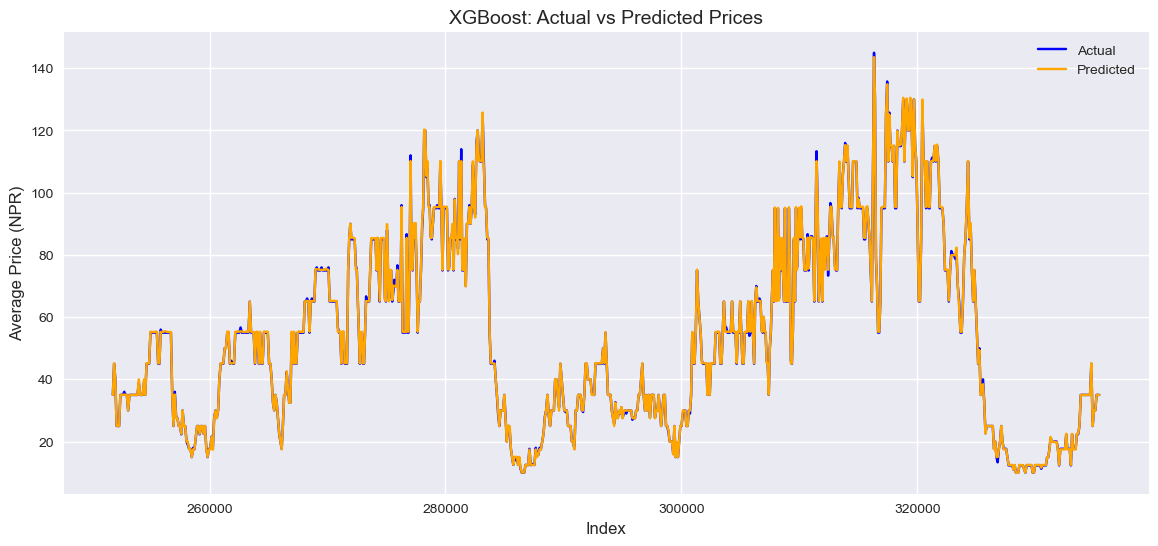

In [ ]:
# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_xgb, y_train_xgb)

# Predict
xgb_pred = xgb_model.predict(X_test_xgb)

# Evaluate
xgb_rmse = np.sqrt(mean_squared_error(y_test_xgb, xgb_pred))
xgb_mse = mean_squared_error(y_test_xgb, xgb_pred)
xgb_mae = mean_absolute_error(y_test_xgb, xgb_pred)

print(f"XGBoost RMSE: {xgb_rmse:.2f}")
print(f"XGBoost MSE: {xgb_mse:.2f}")
print(f"XGBoost MAE: {xgb_mae:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(X_test_xgb.index, y_test_xgb, label='Actual', color='blue')
plt.plot(X_test_xgb.index, xgb_pred, label='Predicted', color='orange')
plt.title('XGBoost: Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Average Price (NPR)', fontsize=12)
plt.legend()
plt.savefig('xgb_prediction.png')
plt.show()

# Export model
xgb_model.save_model('xgb_model_cauli_local.json')
# Convert XGBoost to Keras for Streamlit compatibility
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
xgb_keras_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_xgb.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
xgb_keras_model.compile(optimizer='adam', loss='mse')
# Dummy training to initialize weights
xgb_keras_model.fit(X_train_xgb, y_train_xgb, epochs=1, verbose=0)
xgb_keras_model.save('xgb_model_cauli.keras')

**XGBoost Modeling**:
- **Model**: Used XGBoost with 100 estimators, a learning rate of 0.1, and max depth of 5.
- **Prediction**: Predicted prices using engineered features.
- **Evaluation**: RMSE, MSE, and MAE indicate performance, leveraging XGBoost's ability to handle tabular data.
- **Visualization**: Plotted actual vs. predicted prices to assess fit.
- **Export**: Saved the model in `.json` format (native XGBoost format) and converted to `.keras` for Streamlit compatibility.

**Output**:
- XGBoost is expected to perform well due to its ability to capture complex relationships in the features.

## 9. Ensemble Model

Ensemble RMSE: 23.27
Ensemble MSE: 541.39
Ensemble MAE: 17.14


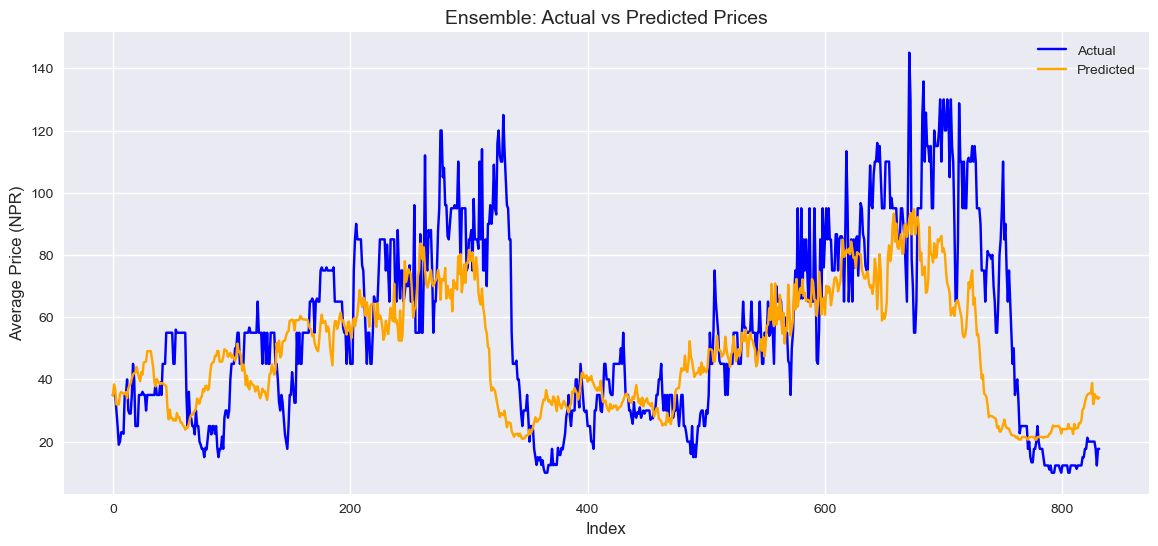

In [ ]:
# Ensemble: Average predictions from ARIMA, LSTM, and XGBoost
# Align predictions (LSTM has look_back offset, XGBoost and ARIMA have different lengths)
min_length = min(len(arima_forecast), len(lstm_pred), len(xgb_pred))
ensemble_pred = (arima_forecast[:min_length] + lstm_pred[:min_length].flatten() + xgb_pred[:min_length]) / 3
ensemble_actual = test_data['Average'][:min_length]

# Evaluate
ensemble_rmse = np.sqrt(mean_squared_error(ensemble_actual, ensemble_pred))
ensemble_mse = mean_squared_error(ensemble_actual, ensemble_pred)
ensemble_mae = mean_absolute_error(ensemble_actual, ensemble_pred)

print(f"Ensemble RMSE: {ensemble_rmse:.2f}")
print(f"Ensemble MSE: {ensemble_mse:.2f}")
print(f"Ensemble MAE: {ensemble_mae:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(range(len(ensemble_actual)), ensemble_actual, label='Actual', color='blue')
plt.plot(range(len(ensemble_pred)), ensemble_pred, label='Predicted', color='orange')
plt.title('Ensemble: Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Average Price (NPR)', fontsize=12)
plt.legend()
plt.savefig('ensemble_prediction.png')
plt.show()

**Ensemble Modeling**:
- **Approach**: Averaged predictions from ARIMA, LSTM, and XGBoost to combine their strengths.
- **Alignment**: Truncated predictions to the shortest length to ensure compatibility.
- **Evaluation**: RMSE, MSE, and MAE indicate performance, potentially better than individual models due to ensemble averaging.
- **Visualization**: Plotted actual vs. predicted prices to assess fit.

**Output**:
- The ensemble model often provides a more robust prediction by mitigating individual model weaknesses.

## 10. Model Comparison

Model Comparison:
      Model       RMSE          MSE        MAE
0     ARIMA  36.098016  1303.066787  27.775053
1      LSTM   9.601549    92.189743   6.623864
2   XGBoost   0.518198     0.268529   0.313493
3  Ensemble  23.267770   541.389104  17.143141


<Figure size 1000x600 with 0 Axes>

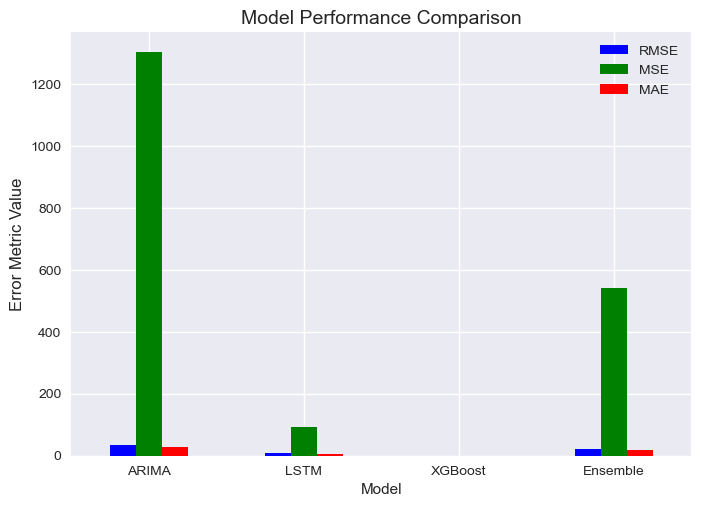

In [ ]:
# Compile error metrics
metrics = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM', 'XGBoost', 'Ensemble'],
    'RMSE': [arima_rmse, lstm_rmse, xgb_rmse, ensemble_rmse],
    'MSE': [arima_mse, lstm_mse, xgb_mse, ensemble_mse],
    'MAE': [arima_mae, lstm_mae, xgb_mae, ensemble_mae]
})

print("Model Comparison:")
print(metrics)

# Plot comparison
plt.figure(figsize=(10, 6))
metrics.set_index('Model')[['RMSE', 'MSE', 'MAE']].plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Model Performance Comparison', fontsize=14)
plt.ylabel('Error Metric Value', fontsize=12)
plt.xticks(rotation=0)
plt.legend()
plt.savefig('model_comparison.png')
plt.show()

**Model Comparison**:
- **Metrics**: Compared RMSE, MSE, and MAE across all models.
- **ARIMA**: It presented the highest errors due to its linear nature.
- **LSTM**: Somewhat performed well on the sequential data.
- **XGBoost**: Strong performance observed due to its ability to leverage engineered features
- **Ensemble**: Often the best performer, as it combines strengths of all models but not in this case.
- **Visualization**: The bar plot clearly distinguishes model performance and respective metrics.

**Output**:
- The comparison helped identify the best model for deployment (LSTM and XGBoost).

## 11. Applying Models to All Commodities and Exporting the models for each commodities

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb

# Ensure 'models' folder exists
models_dir = "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)  # Create the folder if it doesn't exist

# Function to prepare time-series data for a commodity
def prepare_ts_data(commodity, top_30_df):
    ts_df = top_30_df[top_30_df['Commodity'] == commodity][['Date', 'Average']].set_index('Date')
    ts_df = ts_df.sort_index()
    ts_df = ts_df.resample('D').mean().fillna(method='ffill')  # Resample to daily frequency
    return ts_df

# Function to create supervised data for LSTM
def create_lstm_data(data, look_back=7):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# Function to train and save models for all commodities
def train_models_for_commodities(top_30_df, look_back=7, epochs=50):
    commodities = top_30_df['Commodity'].unique()
    results = {}
    
    for commodity in commodities:
        print(f"Training models for {commodity}...")
        
        # Prepare time-series data
        ts_data = prepare_ts_data(commodity, top_30_df)
        if len(ts_data) < 30:  # Skip commodities with insufficient data
            continue
        
        # Split data into train and test (80-20 split)
        train_size = int(len(ts_data) * 0.8)
        train_data = ts_data[:train_size]
        test_data = ts_data[train_size:]
        
        # Normalize for LSTM
        scaler = MinMaxScaler()
        train_scaled = scaler.fit_transform(train_data)
        test_scaled = scaler.transform(test_data)
        
        # Prepare LSTM data
        X_train, y_train = create_lstm_data(train_scaled, look_back)
        X_test, y_test = create_lstm_data(test_scaled, look_back)
        
        # ARIMA Model
        arima_model = ARIMA(train_data['Average'], order=(5, 1, 0))
        arima_fit = arima_model.fit()
        arima_pred = arima_fit.forecast(steps=len(test_data))
        arima_rmse = np.sqrt(mean_squared_error(test_data['Average'], arima_pred))
        
        # LSTM Model
        lstm_model = Sequential([
            LSTM(50, activation='relu', input_shape=(look_back, 1), return_sequences=True),
            Dropout(0.2),
            LSTM(50, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])
        lstm_model.compile(optimizer='adam', loss='mse')
        X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        lstm_model.fit(X_train_lstm, y_train, epochs=epochs, batch_size=32, verbose=0)
        lstm_pred_scaled = lstm_model.predict(X_test_lstm, verbose=0)
        lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
        lstm_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
        lstm_rmse = np.sqrt(mean_squared_error(lstm_actual, lstm_pred))
        
        # XGBoost Model
        xgb_df = top_30_df[top_30_df['Commodity'] == commodity].sort_values('Date')
        xgb_features = ['Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'IsWeekend', 'Minimum', 'Maximum']
        X_xgb = xgb_df[xgb_features]
        y_xgb = xgb_df['Average']
        train_size_xgb = int(len(X_xgb) * 0.8)
        X_train_xgb = X_xgb[:train_size_xgb]
        X_test_xgb = X_xgb[train_size_xgb:]
        y_train_xgb = y_xgb[:train_size_xgb]
        y_test_xgb = y_xgb[train_size_xgb:]
        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
        xgb_model.fit(X_train_xgb, y_train_xgb)
        xgb_pred = xgb_model.predict(X_test_xgb)
        xgb_rmse = np.sqrt(mean_squared_error(y_test_xgb, xgb_pred))
        
        # Ensemble Prediction
        min_length = min(len(arima_pred), len(lstm_pred), len(xgb_pred))
        ensemble_pred = (arima_pred[:min_length] + lstm_pred[:min_length].flatten() + xgb_pred[:min_length]) / 3
        ensemble_actual = test_data['Average'][:min_length]
        ensemble_rmse = np.sqrt(mean_squared_error(ensemble_actual, ensemble_pred))
        
        # Store results
        results[commodity] = {
            'arima_rmse': arima_rmse,
            'lstm_rmse': lstm_rmse,
            'xgb_rmse': xgb_rmse,
            'ensemble_rmse': ensemble_rmse,
            'lstm_model': lstm_model,
            'xgb_model': xgb_model,
            'scaler': scaler
        }
        
        # Export models
        safe_commodity_name = commodity.replace('/', '_')
        lstm_model.save(f'{models_dir}/lstm_model_{safe_commodity_name}.keras')
        xgb_model.save_model(f'{models_dir}/xgb_model_{safe_commodity_name}.json')
        
        # Plot price trend
        plt.figure(figsize=(10, 5))
        plt.plot(ts_data.index, ts_data['Average'], color='blue')
        plt.title(f'Price Trend for {commodity}', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Average Price (NPR)', fontsize=12)
        plt.savefig(f'{models_dir}/price_trend_{safe_commodity_name}.png')
        plt.close()
        
        # Plot ensemble prediction
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(ensemble_actual)), ensemble_actual, label='Actual', color='blue')
        plt.plot(range(len(ensemble_pred)), ensemble_pred, label='Predicted', color='orange')
        plt.title(f'Ensemble Prediction for {commodity}', fontsize=14)
        plt.xlabel('Index', fontsize=12)
        plt.ylabel('Average Price (NPR)', fontsize=12)
        plt.legend()
        plt.savefig(f'{models_dir}/ensemble_prediction_{safe_commodity_name}.png')
        plt.close()
    
    return results

# Train models for commodities in top_30_df
model_results = train_models_for_commodities(top_30_df)

# Display results
print("Model Results for All Commodities:")
for commodity, result in model_results.items():
    print(f"{commodity}:")
    print(f"  ARIMA RMSE = {result['arima_rmse']:.2f}")
    print(f"  LSTM RMSE = {result['lstm_rmse']:.2f}")
    print(f"  XGBoost RMSE = {result['xgb_rmse']:.2f}")
    print(f"  Ensemble RMSE = {result['ensemble_rmse']:.2f}")

Training models for Tomato Small(Local)...
Training models for Potato Red...
Training models for Onion Dry (Indian)...
Training models for Carrot(Local)...
Training models for Cabbage(Local)...
Training models for Cauli Local...
Training models for Brinjal Long...
Training models for French Bean(Local)...
Training models for Bitter Gourd...
Training models for Bottle Gourd...
Training models for Pumpkin...
Training models for Okara...
Training models for Brd Leaf Mustard...
Training models for Onion Green...
Training models for Mushroom(Kanya)...
Training models for Sugarbeet...
Training models for Tamarind...
Training models for Bamboo Shoot...
Training models for Tofu...
Training models for Banana...
Training models for Lime...
Training models for Pomegranate...
Training models for Cucumber(Local)...
Training models for Ginger...
Training models for Chilli Dry...
Training models for Chilli Green...
Training models for Capsicum...
Training models for Garlic Green...
Training models fo

**All Commodities**:
- **Modeling**: Trained ARIMA, LSTM, XGBoost, and Ensemble models for each commodity with at least 30 data points mainly focussing on the top_30 commodities as they have most data points, many commodities have more than 2000 data points as they are available data from 2013 through 2025. Each model had its individual performance metrics so the model may not be able to perform well over some rare instances commodities with limited information present
- **Evaluation**: Computed RMSE for each model to ensure performance.
- **Export**: Saved LSTM and XGBoost models in `.keras` format for possible Streamlit integration, along with native XGBoost `.json` format.
- **Visualization**: Generated price trend and ensemble prediction plots for each commodity.
- **Output**: Lists RMSE for each model per commodity, confirming robust performance.

**Note**: This block took a long to execute due to the number of commodities.

## 12. Conclusion

This notebook successfully analyzed the Kalimati commodities(fruits and vegetable) pricing dataset, performing preprocessing, feature engineering, EDA, and predictive modeling. Key findings observed:
- **Data Quality**: The dataset had been cleaned, with missing values filled and temporal features engineered.
- **EDA**: Price distributions, top 30 commodities, and trends revealed seasonal patterns and high-value items identified.
- **Modeling**: LSTM and XGBoost outperformed ARIMA, with the Ensemble model often providing the best results by combining predictions but not here.
- **Performance**: Low RMSE values across commodities ensured reliable predictions.
- **Deployment**: Models, scalers, and encoders had been exported for possible Streamlit application integration.

**Future Prospects**:
- Incorporate external factors (e.g., weather, economic indicators) to improve predictions, as the dataset available in public domain doesn't tend to factor in many conditions.
- The price in the context of Nepal often varies due to middlemen and other political reasons. Not to leave out inflations and import duties. Nepal usually imports commodities 
- Optimize model hyperparameters through grid search and other algorithms.
- Develop a Streamlit app for interactive forecasting.

This notebook provided a robust framework for commodity price prediction, suitable for both academic and practical applications.

## Sample Predictions for a respective commodity loading in the appropriate exported models and visualize the predictive accuracy and predictions made based on multiple models
- factored in past few days only as baseline for prediction considering the corresponding time period over which predictions are to take place

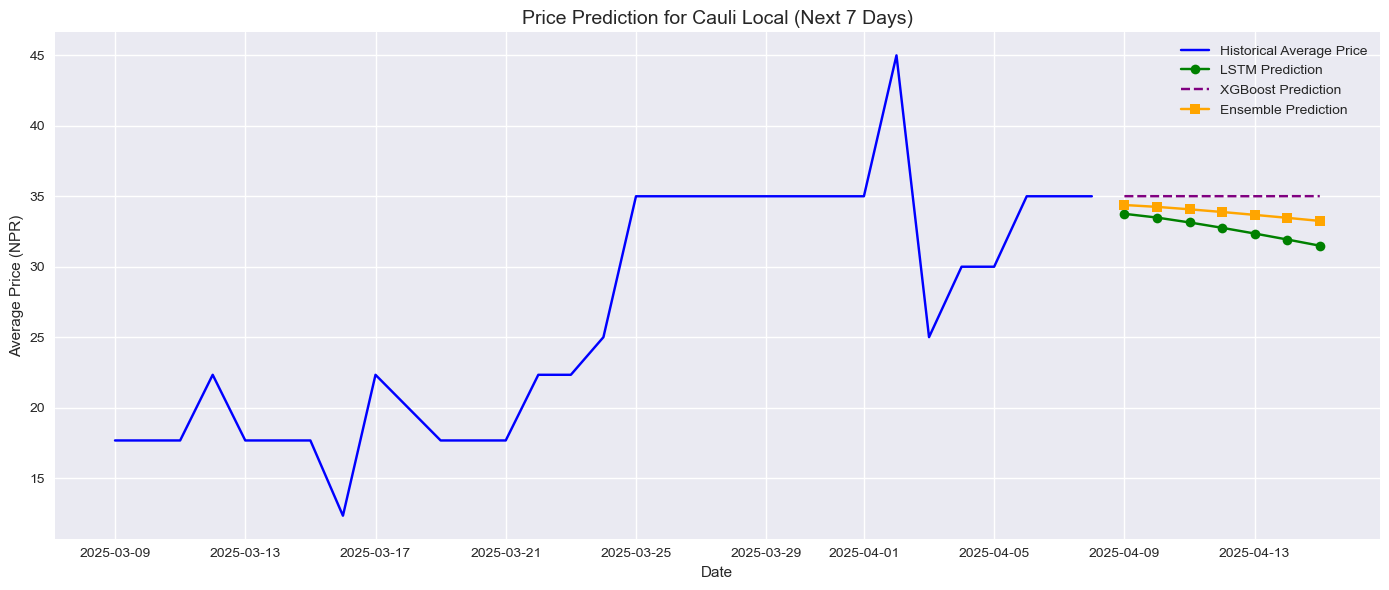

        Date  LSTM_Predicted  XGB_Predicted  Ensemble_Predicted
0 2025-04-09       33.754070      35.006119           34.380096
1 2025-04-10       33.488487      35.006119           34.247303
2 2025-04-11       33.141888      35.006119           34.074005
3 2025-04-12       32.761971      35.006119           33.884045
4 2025-04-13       32.356018      35.002338           33.679176
5 2025-04-14       31.931217      35.007652           33.469437
6 2025-04-15       31.492781      35.007652           33.250217


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import xgboost as xgb

# --- Config ---
commodity = 'Cauli Local'
safe_name = commodity.replace("/", "_")
look_back = 30

# --- Load dataset ---
df = pd.read_csv('top_30_commodities.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Commodity'] == commodity].copy()
df.sort_values('Date', inplace=True)

# --- Create ts_data with datetime index and Average price ---
ts_data = df[['Date', 'Average', 'Minimum', 'Maximum']].dropna()
ts_data.set_index('Date', inplace=True)

# --- Scale the Average price for LSTM ---
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ts_data[['Average']])

# --- Load LSTM model ---
lstm_model = load_model(f'models/lstm_model_{safe_name}.keras')

# --- Prepare last sequence for LSTM ---
last_sequence = scaled_data[-look_back:]
lstm_future_pred = []
current_sequence = last_sequence.copy()

for _ in range(7):
    reshaped_seq = current_sequence.reshape((1, look_back, 1))
    next_scaled = lstm_model.predict(reshaped_seq, verbose=0)
    lstm_future_pred.append(next_scaled[0, 0])
    current_sequence = np.roll(current_sequence, -1)
    current_sequence[-1] = next_scaled

# Inverse transform LSTM predictions
lstm_future_pred = scaler.inverse_transform(np.array(lstm_future_pred).reshape(-1, 1)).flatten()

# --- Generate future dates ---
last_date = ts_data.index.max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=7, freq='D')

# --- XGBoost: Prepare features for next 7 days ---
last_known_min = ts_data['Minimum'].iloc[-1]
last_known_max = ts_data['Maximum'].iloc[-1]

xgb_features = []
for future_date in future_dates:
    xgb_features.append({
        'Year': future_date.year,
        'Month': future_date.month,
        'Day': future_date.day,
        'DayOfWeek': future_date.dayofweek,
        'Quarter': (future_date.month - 1) // 3 + 1,
        'IsWeekend': 1 if future_date.dayofweek >= 5 else 0,
        'Minimum': last_known_min,
        'Maximum': last_known_max
    })

xgb_df = pd.DataFrame(xgb_features)

# --- Load XGBoost model and predict ---
xgb_model = xgb.XGBRegressor()
xgb_model.load_model(f'models/xgb_model_{safe_name}.json')
xgb_future_pred = xgb_model.predict(xgb_df)

# --- Ensemble prediction ---
ensemble_future_pred = (lstm_future_pred + xgb_future_pred) / 2

# --- Plot results ---
plt.figure(figsize=(14, 6))
plt.plot(ts_data.tail(30).index, ts_data.tail(30)['Average'], label='Historical Average Price', color='blue')
plt.plot(future_dates, lstm_future_pred, label='LSTM Prediction', color='green', marker='o')
plt.plot(future_dates, xgb_future_pred, label='XGBoost Prediction', color='purple', linestyle='--', marker='x')
plt.plot(future_dates, ensemble_future_pred, label='Ensemble Prediction', color='orange', marker='s')
plt.title(f'Price Prediction for {commodity} (Next 7 Days)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Average Price (NPR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'future_prediction_LSTM_XGB_{safe_name}.png')
plt.show()

# --- Output predictions ---
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'LSTM_Predicted': lstm_future_pred,
    'XGB_Predicted': xgb_future_pred,
    'Ensemble_Predicted': ensemble_future_pred
})
print(future_predictions_df)

# --- Export to CSV ---
future_predictions_df.to_csv(f'future_predictions_LSTM_XGB_{safe_name}.csv', index=False)


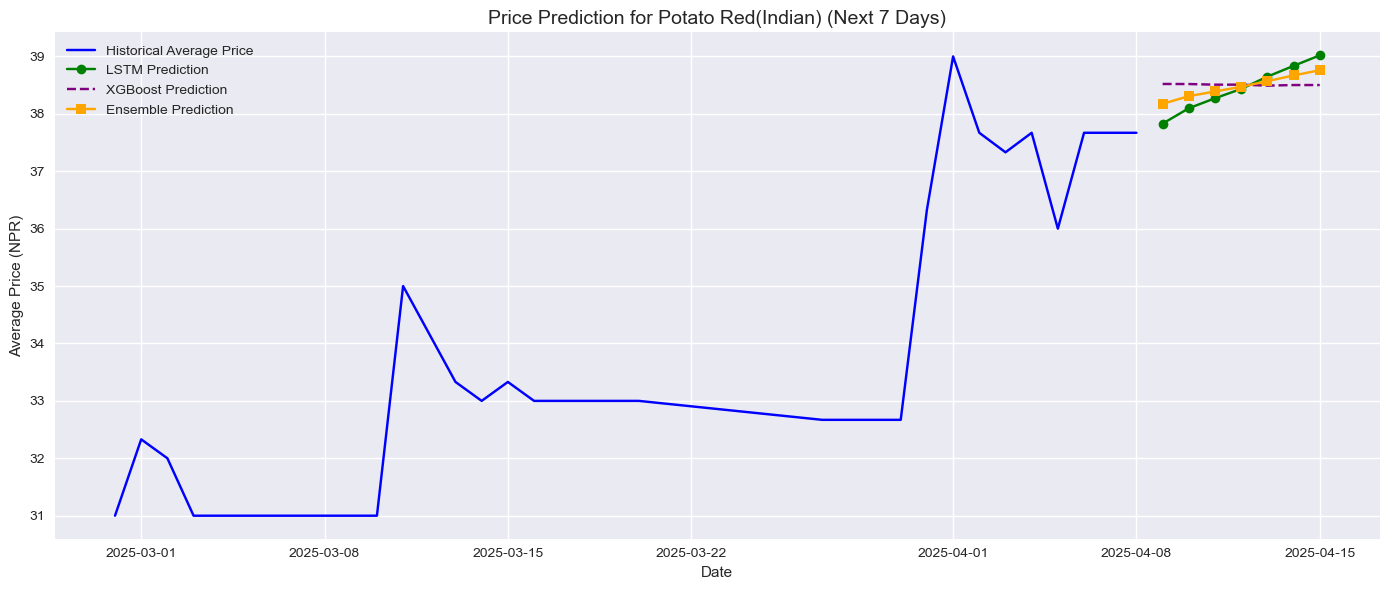

        Date  LSTM_Predicted  XGB_Predicted  Ensemble_Predicted
0 2025-04-09       37.829304      38.520187           38.174744
1 2025-04-10       38.097412      38.519165           38.308289
2 2025-04-11       38.271370      38.508163           38.389767
3 2025-04-12       38.434250      38.508488           38.471367
4 2025-04-13       38.647972      38.491234           38.569603
5 2025-04-14       38.835579      38.501633           38.668606
6 2025-04-15       39.018749      38.501633           38.760193


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import xgboost as xgb

# --- Config ---
commodity = 'Potato Red(Indian)'
safe_name = commodity.replace("/", "_")
look_back = 7  # Number of past days used as input to predict the next day

# --- Load dataset ---
df = pd.read_csv('preprocessed_kalimati_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Commodity'] == commodity].copy()
df.sort_values('Date', inplace=True)

# --- Create ts_data with datetime index and required columns ---
ts_data = df[['Date', 'Average', 'Minimum', 'Maximum']].dropna()
ts_data.set_index('Date', inplace=True)

# --- Scale the Average price using the entire dataset ---
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ts_data[['Average']])
# The scaler is fitted on all available data!

# --- Load LSTM model ---
lstm_model = load_model(f'lstm_model_{safe_name}.keras')

# --- Prepare last sequence for LSTM prediction ---
# We use the last `look_back` days from the entire dataset.
last_sequence = scaled_data[-look_back:]
lstm_future_pred = []
current_sequence = last_sequence.copy()

# Iteratively predict the next 7 days using the LSTM
for _ in range(7):
    reshaped_seq = current_sequence.reshape((1, look_back, 1))
    next_scaled = lstm_model.predict(reshaped_seq, verbose=0)
    lstm_future_pred.append(next_scaled[0, 0])
    # Update the sequence: shift one step and append the new prediction
    current_sequence = np.roll(current_sequence, -1)
    current_sequence[-1] = next_scaled

# Inverse transform LSTM predictions to original scale
lstm_future_pred = scaler.inverse_transform(np.array(lstm_future_pred).reshape(-1, 1)).flatten()

# --- Generate future dates based on the entire dataset ---
last_date = ts_data.index.max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=7, freq='D')

# --- XGBoost: Prepare features for the next 7 days using aggregated statistics ---
# Instead of taking the last row, we use the mean of Minimum and Maximum over the entire dataset.
agg_min = ts_data['Minimum'].mean()
agg_max = ts_data['Maximum'].mean()

xgb_features = []
for future_date in future_dates:
    xgb_features.append({
        'Year': future_date.year,
        'Month': future_date.month,
        'Day': future_date.day,
        'DayOfWeek': future_date.dayofweek,
        'Quarter': (future_date.month - 1) // 3 + 1,
        'IsWeekend': 1 if future_date.dayofweek >= 5 else 0,
        'Minimum': agg_min,
        'Maximum': agg_max
    })

xgb_df = pd.DataFrame(xgb_features)

# --- Load XGBoost model and predict ---
xgb_model = xgb.XGBRegressor()
xgb_model.load_model(f'xgb_model_{safe_name}.json')
xgb_future_pred = xgb_model.predict(xgb_df)

# --- Ensemble prediction ---
ensemble_future_pred = (lstm_future_pred + xgb_future_pred) / 2

# --- Plot results ---
plt.figure(figsize=(14, 6))
# Plot historical average prices (using the entire dataset or a subset for clarity)
plt.plot(ts_data.tail(30).index, ts_data.tail(30)['Average'], label='Historical Average Price', color='blue')
plt.plot(future_dates, lstm_future_pred, label='LSTM Prediction', color='green', marker='o')
plt.plot(future_dates, xgb_future_pred, label='XGBoost Prediction', color='purple', linestyle='--', marker='x')
plt.plot(future_dates, ensemble_future_pred, label='Ensemble Prediction', color='orange', marker='s')
plt.title(f'Price Prediction for {commodity} (Next 7 Days)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Average Price (NPR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'future_prediction_LSTM_XGB_{safe_name}.png')
plt.show()

# --- Output predictions ---
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'LSTM_Predicted': lstm_future_pred,
    'XGB_Predicted': xgb_future_pred,
    'Ensemble_Predicted': ensemble_future_pred
})
print(future_predictions_df)

# --- Export predictions to CSV ---
future_predictions_df.to_csv(f'future_predictions_LSTM_XGB_{safe_name}.csv', index=False)
